# Evaluation models

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

#from pytvision.datasets.factory  import FactoryDataset 
from pytvision.datasets.datasets import Dataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

from torchcls.datasets.factory import FactoryDataset 
from torchcls.neuralnet import NeuralNetClassifier

from sklearn import metrics

plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATASET_PATH = '/.datasets'
DATASET_NAME = FactoryDataset.Datasets.MNIST
print("Selected dataset {} in {}".format(DATASET_NAME.to_str(), DATASET_PATH))

Selected dataset mnist in /.datasets


In [3]:
PROJECT='../out/netruns'
no_cuda=False
seed=1
gpu=0
batch_size=4
workers=4
num_input_channels=3

In [4]:
!ls ../out/netruns/

torchcls_preactresnet18_cross_adam_mnist_v0.02
torchcls_preactresnet18_cross_adam_touchdraw_v0.02


In [5]:
NAME = 'torchcls_preactresnet18_cross_adam_mnist_v0.02'
PROJECTNAME = os.path.join(PROJECT, NAME)
MODEL = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
PATHMODEL = os.path.join(PROJECTNAME,'models',MODEL)

print(PROJECTNAME)
print(PATHMODEL)

../out/netruns/torchcls_preactresnet18_cross_adam_mnist_v0.02
../out/netruns/torchcls_preactresnet18_cross_adam_mnist_v0.02/models/model_best.pth.tar


In [6]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=PROJECTNAME,
    nameproject=NAME,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( PATHMODEL ) is not True:
    assert(False)

=> loading checkpoint '../out/netruns/torchcls_preactresnet18_cross_adam_mnist_v0.02/models/model_best.pth.tar'
=> loaded checkpoint for preactresnet18 arch!


In [7]:

SUBSET=FactoryDataset.Subsets.VAL

data = Dataset(
    data=FactoryDataset.factory(
        pathname=DATASET_PATH, 
        name=DATASET_NAME, 
        subset=SUBSET, 
        download=True),
    num_channels=3,
    transform=transforms.Compose([
        mtrans.ToResize( (48, 48), resize_mode='squash', padding_mode=cv2.BORDER_REPLICATE ),
        mtrans.ToTensor(),
        mtrans.ToNormalization(),
        ])
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader')
print(len(dataloader))
print(len(data))

Data loader
2500
10000


In [8]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame(np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(PROJECTNAME , '{}_{}_{}_dp.csv'.format(SUBSET, NAME, DATASET_NAME)), index=False, encoding='utf-8')       

print('dir: {}'.format(PROJECTNAME))
print('DONE!!!')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 320.85it/s]


dir: ../out/netruns/torchcls_preactresnet18_cross_adam_mnist_v0.02
DONE!!!


In [9]:
df = pd.read_csv( os.path.join(PROJECTNAME , '{}_{}_{}_dp.csv'.format(SUBSET, NAME, DATASET_NAME)) )
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,2.221716e-07,8.594309e-05,0.000217,0.000073,0.000177,0.000479,3.757292e-08,9.974805e-01,0.000004,0.001483,7.0
1,7.936359e-07,9.910474e-07,0.995596,0.000103,0.000002,0.004103,1.432548e-05,1.659982e-04,0.000012,0.000001,2.0
2,5.794052e-06,9.982811e-01,0.000035,0.000013,0.000128,0.000006,3.188368e-05,1.244493e-03,0.000002,0.000253,1.0
3,9.907918e-01,3.406850e-07,0.000030,0.000061,0.000001,0.000211,2.621010e-04,6.035283e-07,0.000038,0.008604,0.0
4,7.138544e-04,1.132304e-06,0.000051,0.000127,0.951346,0.000395,8.203421e-03,7.638910e-07,0.000098,0.039063,4.0


In [10]:
result = df.values
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='weighted')
recall = metrics.recall_score(y, yhat, average='weighted')
f1_score = 2*precision*recall/(precision+recall)

# print('Accuracy : %f' % acc)
# print('Precision : %f' % precision)
# print('Recall : %f' % recall)
# print('F1 score : %f' % f1_score)
# print("")
print('|Acc\t|Prec\t|Rec\t|F1\t|')
print( '|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|'.format(acc,precision,recall,f1_score).replace('.',',')  )

print()
print( '{:0.3f}\n{:0.3f}\n{:0.3f}\n{:0.3f}'.format(acc*100,precision*100,recall*100,f1_score*100).replace('.',',')  )

|Acc	|Prec	|Rec	|F1	|
|0,959	|0,960	|0,959	|0,960	|

95,920
96,035
95,920
95,978


In [11]:
metric = metrics.classification_report(y, yhat)
print(metric)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.97      0.93      0.95      1032
         3.0       0.93      0.99      0.96      1010
         4.0       0.99      0.89      0.93       982
         5.0       0.92      0.95      0.93       892
         6.0       0.96      0.95      0.95       958
         7.0       0.97      0.97      0.97      1028
         8.0       0.99      0.97      0.98       974
         9.0       0.90      0.97      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [12]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)
# print( np.diag( mc ) )

[[ 969    0    3    0    0    2    3    1    1    1]
 [   0 1120    3    5    1    0    0    6    0    0]
 [   0    0  960   16    1   33   16    4    1    1]
 [   0    0    1  997    0    7    0    4    1    0]
 [   3    1    1    0  870    0   22    1    0   84]
 [   1    1    1   36    0  843    1    9    0    0]
 [   5    6   10    2    1   16  912    0    6    0]
 [   0    2   10    9    5    2    0  995    0    5]
 [   0    0    2    2    0    2    0    2  947   19]
 [   6    0    0    6    1    8    0    8    1  979]]


Normalized confusion matrix
[98.87755102 98.6784141  93.02325581 98.71287129 88.59470468 94.50672646
 95.19832985 96.78988327 97.22792608 97.02675917]


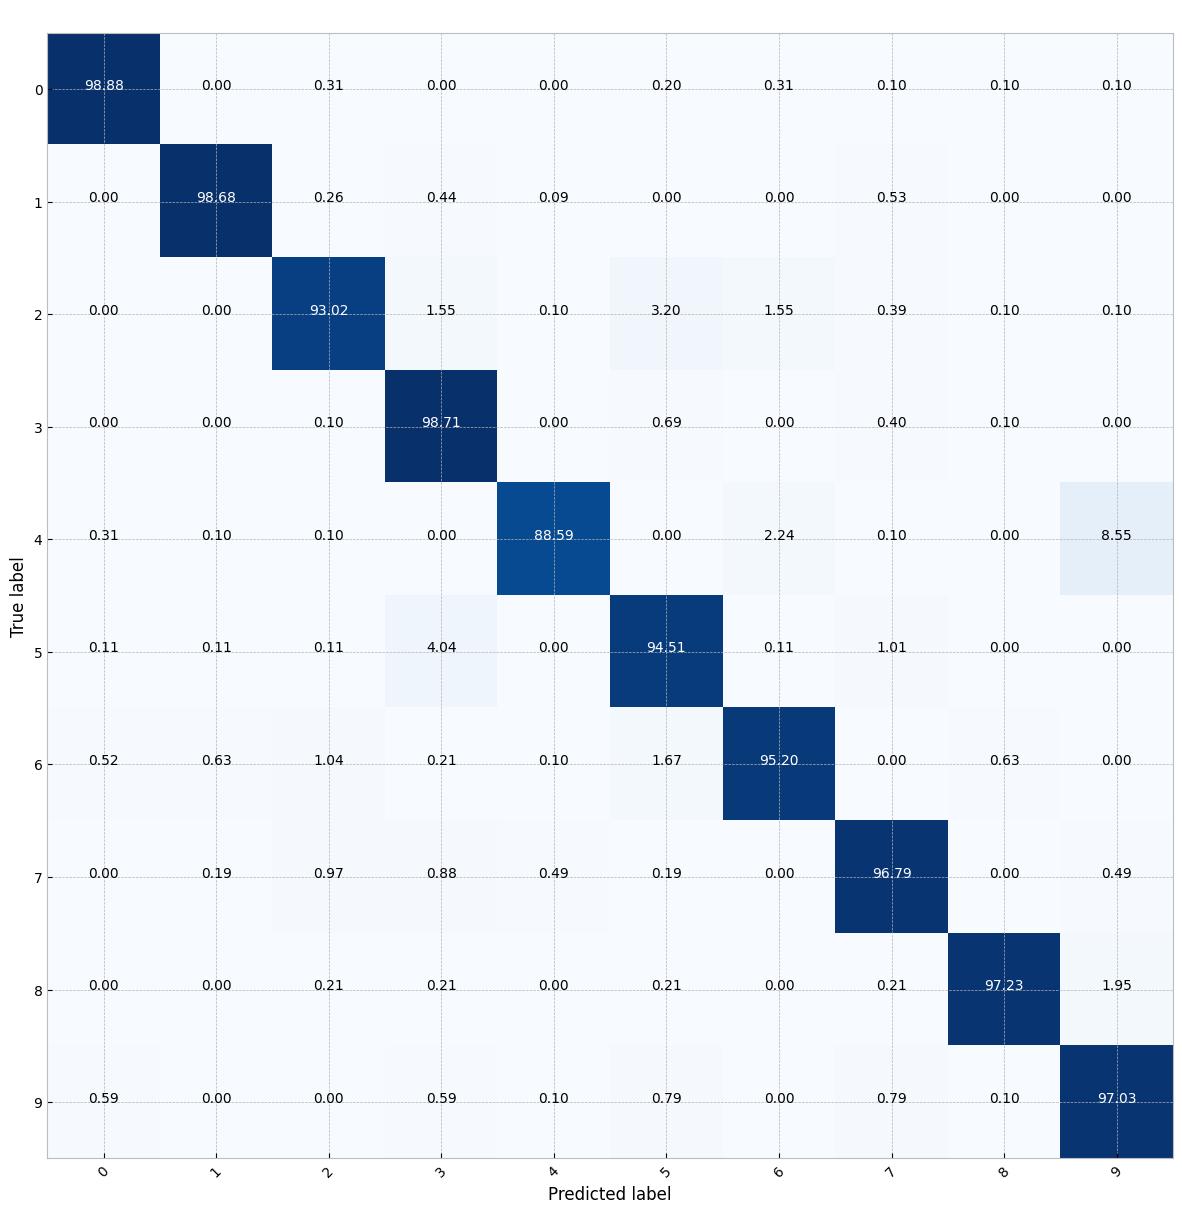

In [13]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    print( np.diag(cm) )

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


matplotlib.style.use('bmh')
plt.figure( figsize=(12,12))
plot_confusion_matrix(mc, classes=data.classes, title=' ',  normalize=True)
# plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.grid('off')
plt.show()